# Census Rebalancing

In this notebook, we examine the proportions of individuals in our collected "representative" samples relative to census data for the UK and the US. Then we rebalance the sample as best as we can according to census breakdowns.

Please read the Supplementary Materials of our paper for more details!

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import (
    load_data,
    unnest_columns,
)

from src.viz.plot_config import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set a random seed for reproducibility
np.random.seed(42)

# Set data path
PROJECT_ROOT = find_project_root()
INPUT_PATH = PROJECT_ROOT / "data"
RESULTS_PATH = PROJECT_ROOT / "results" / "plots"

# Load data
data_dict = load_data(INPUT_PATH)
# Unpack dictionary
for key, dataset in data_dict.items():
    # Unnest the survey columns for ease of analysis
    if key == "survey":
        nested_columns = ["location", "religion", "ethnicity"]
        dataset = unnest_columns(dataset, nested_columns)
        data_dict[key] = dataset

survey = data_dict["survey"]
conversations = data_dict["conversations"]

# Subset survey data to individuals who also have conversations
print("Number of respondants:", len(survey))
survey_w_convos = survey[survey["survey_only"] == False]
print("Number of respondants with conversations:", len(survey_w_convos))

# Get individuals who have conversations in the balanced subset
ids_with_balanced_subset = conversations["user_id"][
    conversations["included_in_balanced_subset"] == True
].unique()
print(
    "Number of respondents with balanced conversations:", len(ids_with_balanced_subset)
)

# Map these ids back to survey
survey["included_in_balanced_subset"] = survey["user_id"].isin(ids_with_balanced_subset)
assert len(survey[survey["included_in_balanced_subset"] == True]) == len(
    ids_with_balanced_subset
)

survey_w_balanced_convos = survey[
    (survey["survey_only"] == False) & (survey["included_in_balanced_subset"] == True)
]
assert len(survey_w_balanced_convos) == len(ids_with_balanced_subset)

# Storage
data_dict = {
    "survey": survey,
    "survey_w_convos": survey_w_convos,
    "survey_w_balanced_convos": survey_w_balanced_convos,
}

Number of respondants: 1500
Number of respondants with conversations: 1396
Number of respondents with balanced conversations: 1246


# Comparing to Census

First let's inspect how our samples compare to census data.

## Get Observed Counts in Each Census Cross-Tab

In [2]:
def pivot_counts(study):
    # Pivot
    pivot_table = pd.pivot_table(
        study,
        values="user_id",  # Assuming this column can be used for counting
        index="age",
        columns=["ethnicity_remapped", "gender"],
        aggfunc="count",
        fill_value=0,
    )

    # Reset index to make 'age' a column again
    pivot_table.reset_index(inplace=True)

    # Rename the columns for consistency
    pivot_table.columns = [
        f"{ethnicity}_{gender}" for ethnicity, gender in pivot_table.columns
    ]
    # Rename age
    pivot_table.rename(columns={"age_": "age_category"}, inplace=True)

    # Get "All", "All_Female" and "All_Male"
    all_cols = [col for col in pivot_table.columns if "age" not in col]
    female_cols = [col for col in pivot_table.columns if "Female" in col]
    male_cols = [col for col in pivot_table.columns if "Male" in col]
    pivot_table["All"] = pivot_table[all_cols].sum(axis=1)
    pivot_table["All_Male"] = pivot_table[male_cols].sum(axis=1)
    pivot_table["All_Female"] = pivot_table[female_cols].sum(axis=1)

    # Set index as age
    pivot_table.set_index("age_category", inplace=True)

    # Total population
    pivot_table["Total"] = pivot_table["All"].sum()

    # Divide every cell by total population
    pivot_table = pivot_table.apply(lambda x: (x / x["Total"]) * 100, axis=1)

    # Add a row for all ages
    pivot_table.loc["All Ages"] = pivot_table.sum(axis=0)

    # Drop total
    pivot_table = pivot_table.drop(columns=["Total"])

    return pivot_table

In [3]:
def get_our_crosstabs_by_census(
    survey, locale, eth_mapping, location_column="study_locale"
):
    study = survey[survey[location_column] == locale]
    study = study.copy()

    # Remap ethnicity
    pre_remap_len = len(study)
    study["ethnicity_remapped"] = (
        study["ethnicity_categorised"].map(eth_mapping).dropna()
    )
    post_remap_len = len(study)
    assert pre_remap_len == post_remap_len

    # Keep binary genders for census comparison
    study = study[study["gender"].isin(["Female", "Male"])]

    # Print counts
    print(f"Number of binary gender respondents in {locale}:", len(study))
    pivot_table = pivot_counts(study)

    return pivot_table

### Sample Parameters

In [4]:
LOCATION_COLUMN = "study_locale"
DATA_SPLIT = "survey_w_balanced_convos"
DATA = data_dict[DATA_SPLIT]

### UK Study

In [5]:
# UK
locale = "uk"

uk_eth_mapping = {
    "White": "White",
    "Hispanic / Latino": "Other",
    "Black / African": "Black",
    "Asian": "Asian",
    "Mixed": "Mixed",
    "Other": "Other",
    "Middle Eastern / Arab": "Other",
    "Indigenous / First Peoples": "Other",
}


uk_ours = get_our_crosstabs_by_census(DATA, locale, uk_eth_mapping, LOCATION_COLUMN)

display(uk_ours)

Number of binary gender respondents in uk: 283


,Asian_Female,Asian_Male,Black_Female,Black_Male,Mixed_Female,Mixed_Male,Other_Female,Other_Male,White_Female,White_Male,All,All_Male,All_Female
age_category,,,,,,,,,,,,,
18-24 years old,0.729927,0.364964,0.000000,0.364964,0.729927,0.000000,0.364964,0.364964,3.284672,3.284672,9.489051,4.379562,5.109489
25-34 years old,0.729927,0.729927,0.729927,1.094891,0.000000,0.000000,0.364964,0.364964,8.394161,8.759124,21.167883,10.948905,10.218978
35-44 years old,0.729927,0.364964,0.364964,0.729927,0.729927,0.364964,0.000000,0.364964,8.394161,7.299270,19.343066,9.124088,10.218978
45-54 years old,0.000000,0.729927,0.364964,0.000000,0.364964,0.364964,0.000000,0.000000,6.204380,7.664234,15.693431,8.759124,6.934307
55-64 years old,0.000000,0.729927,0.364964,0.729927,0.729927,0.000000,0.364964,0.000000,12.043796,8.759124,23.722628,10.218978,13.503650
65+ years old,0.000000,0.000000,0.000000,0.000000,0.364964,0.000000,0.000000,0.000000,4.744526,5.474453,10.583942,5.474453,5.109489
All Ages,2.189781,2.919708,1.824818,2.919708,2.919708,0.729927,1.094891,1.094891,43.065693,41.240876,100.000000,48.905109,51.094891


### US Study

In [6]:
DATA["ethnicity_categorised"][
    DATA["location_reside_countryISO"] == "USA"
].value_counts()

ethnicity_categorised
White                         201
Black / African                30
Hispanic / Latino              22
Mixed                          19
Asian                          19
Prefer not to say               9
Indigenous / First Peoples      1
Name: count, dtype: int64

In [7]:
# US
locale = "us"

us_eth_mapping = {
    "White": "White",
    "Hispanic / Latino": "Other",
    "Black / African": "Black",
    "Asian": "Asian",
    "Mixed": "Mixed",
    "Other": "Other",
    "Middle Eastern / Arab": "Other",
    "Indigenous / First Peoples": "Other",
}


us_ours = get_our_crosstabs_by_census(DATA, locale, us_eth_mapping, LOCATION_COLUMN)

display(us_ours)

Number of binary gender respondents in us: 297


,Asian_Female,Asian_Male,Black_Female,Black_Male,Mixed_Female,Mixed_Male,Other_Female,Other_Male,White_Female,White_Male,All,All_Male,All_Female
age_category,,,,,,,,,,,,,
18-24 years old,0.696864,1.045296,1.045296,0.348432,0.000000,0.000000,1.045296,0.000000,2.787456,2.787456,9.756098,4.181185,5.574913
25-34 years old,0.696864,0.348432,0.348432,1.393728,0.696864,0.696864,1.393728,0.696864,4.878049,6.968641,18.118467,10.104530,8.013937
35-44 years old,0.348432,0.696864,1.393728,0.696864,0.696864,0.696864,0.348432,0.696864,4.529617,4.529617,14.634146,7.317073,7.317073
45-54 years old,1.045296,0.348432,0.696864,1.393728,0.348432,0.696864,0.696864,1.393728,6.968641,8.362369,21.951220,12.195122,9.756098
55-64 years old,1.045296,0.348432,1.393728,0.348432,1.393728,0.696864,0.000000,0.348432,9.059233,6.968641,21.602787,8.710801,12.891986
65+ years old,0.000000,0.000000,1.045296,0.348432,0.000000,0.348432,0.000000,0.696864,5.923345,5.574913,13.937282,6.968641,6.968641
All Ages,3.832753,2.787456,5.923345,4.529617,3.135889,3.135889,3.484321,3.832753,34.146341,35.191638,100.000000,49.477352,50.522648


## Loading and Importing Actual Census Data

### UK Census Cleaning

In [8]:
CENSUS_PATH = PROJECT_ROOT / "data" / "storage" / "census_data"
uk = pd.read_csv(CENSUS_PATH / "uk.csv")

display(uk.head())

# Drop any rows with Age < 18
uk["Age"] = uk["Age"].map(lambda x: pd.to_numeric(x.replace("+", "")))
uk = uk[uk["Age"] >= 18]

# Drop any columns with 2011
uk = uk.drop(columns=[col for col in uk.columns if "2011" in col])

# Drop any columns with pct as we will remap relative to population totals
uk = uk.drop(columns=[col for col in uk.columns if "percentage" in col])

# Get ethnicites
categories = set(col.split(":")[0] for col in uk.columns if ":" in col)
category_remapping = {
    "Black/African/Caribbean/Black British": "Black",
    "White": "White",
    "Asian/Asian British": "Asian",
    "Mixed or Multiple ethnic groups": "Mixed",
    "Other ethnic group": "Other",
}

# Sum the values for each category and store in a new DataFrame
summed_df = pd.DataFrame(index=uk.index)
summed_df["age"] = uk["Age"]
for gender in ["Female", "Male"]:
    # Get female columns
    gender_columns = [col for col in uk.columns if gender in col]
    for category in categories:
        category_columns = [col for col in gender_columns if col.startswith(category)]
        summed_df[f"{category_remapping[category]}_{gender}"] = uk[
            category_columns
        ].sum(axis=1)


# Remap ages into categories
def map_age_to_category(age):
    if age >= 18 and age <= 24:
        return "18-24 years old"
    elif age >= 25 and age <= 34:
        return "25-34 years old"
    elif age >= 35 and age <= 44:
        return "35-44 years old"
    elif age >= 45 and age <= 54:
        return "45-54 years old"
    elif age >= 55 and age <= 64:
        return "55-64 years old"
    elif age >= 65:
        return "65+ years old"
    else:
        return "Prefer not to say"  # or you can choose another way to handle ages not fitting the categories


age_categories = survey["age"].sort_values().unique()
summed_df["age_category"] = summed_df["age"].map(map_age_to_category)
summed_df.drop(columns=["age"], inplace=True)

# Sum across age categories
summed_df = summed_df.groupby(["age_category"]).sum().reset_index()

# Get "All", "All_Female" and "All_Male"
all_cols = [col for col in summed_df.columns if "age" not in col]
female_cols = [col for col in summed_df.columns if "Female" in col]
male_cols = [col for col in summed_df.columns if "Male" in col]
summed_df["All"] = summed_df[all_cols].sum(axis=1)
summed_df["All_Male"] = summed_df[male_cols].sum(axis=1)
summed_df["All_Female"] = summed_df[female_cols].sum(axis=1)

# Set index as age
summed_df.set_index("age_category", inplace=True)

# Total population
summed_df["Total"] = summed_df["All"].sum()
print("Total people UK: ", summed_df["All"].sum())

# Divide every cell by total population
summed_df = summed_df.apply(lambda x: (x / x["Total"]) * 100, axis=1)

# Add a row for all ages
summed_df.loc["All Ages"] = summed_df.sum(axis=0)

uk_census = summed_df.copy()

# Drop total
uk_census = uk_census.drop(columns=["Total"])

display(uk_census)

,Age,"Asian/Asian British: Bangladeshi, Female 2021 (number)","Asian/Asian British: Bangladeshi, Male 2021 (number)","Asian/Asian British: Bangladeshi, Female 2021 (percentage)","Asian/Asian British: Bangladeshi, Male 2021 (percentage)","Asian/Asian British: Chinese, Female 2021 (number)","Asian/Asian British: Chinese, Male 2021 (number)","Asian/Asian British: Chinese, Female 2021 (percentage)","Asian/Asian British: Chinese, Male 2021 (percentage)","Asian/Asian British: Indian, Female 2021 (number)",...,"White: Other White, Female 2011 (percentage)","White: Other White, Male 2011 (percentage)","Other ethnic group: Arab, Female 2011 (number)","Other ethnic group: Arab, Male 2011 (number)","Other ethnic group: Arab, Female 2011 (percentage)","Other ethnic group: Arab, Male 2011 (percentage)","Other ethnic group: Any other ethnic group, Female 2011 (number)","Other ethnic group: Any other ethnic group, Male 2011 (number)","Other ethnic group: Any other ethnic group, Female 2011 (percentage)","Other ethnic group: Any other ethnic group, Male 2011 (percentage)"
0,0,5170,5325,0.80,0.83,1105,1235,0.25,0.28,10275,...,0.72,0.76,2381,2776,1.03,1.20,2511,2493,0.75,0.75
1,1,5660,5720,0.88,0.89,1500,1680,0.34,0.38,10680,...,0.69,0.72,2652,2668,1.15,1.16,2344,2603,0.70,0.78
2,2,5680,5825,0.88,0.90,1570,1690,0.35,0.38,10985,...,0.65,0.71,2496,2654,1.08,1.15,2477,2390,0.74,0.72
3,3,5595,5650,0.87,0.88,1660,1735,0.37,0.39,11365,...,0.60,0.64,2543,2690,1.10,1.17,2391,2426,0.72,0.73
4,4,6005,6145,0.93,0.95,2020,2180,0.45,0.49,11690,...,0.53,0.54,2393,2650,1.04,1.15,2245,2395,0.67,0.72


Total people UK:  47204870


,Asian_Female,Mixed_Female,Black_Female,Other_Female,White_Female,Asian_Male,Mixed_Male,Black_Male,Other_Male,White_Male,All,All_Male,All_Female
age_category,,,,,,,,,,,,,
18-24 years old,0.608783,0.232518,0.278223,0.127476,3.956382,0.636852,0.225189,0.280660,0.139456,4.016100,10.501639,5.298256,5.203383
25-34 years old,1.013645,0.287640,0.391114,0.234224,6.837367,0.897015,0.255101,0.332625,0.223335,6.582351,17.054416,8.290426,8.763990
35-44 years old,1.116040,0.199354,0.420846,0.243280,6.421255,1.020022,0.174654,0.332233,0.243725,6.219581,16.390989,7.990214,8.400775
45-54 years old,0.755494,0.136289,0.397978,0.170798,7.048351,0.756034,0.119405,0.343450,0.184896,6.848626,16.761321,8.252411,8.508910
55-64 years old,0.451892,0.089429,0.293021,0.105699,7.124328,0.428706,0.077365,0.265248,0.116831,6.903122,15.855642,7.791272,8.064369
65+ years old,0.477271,0.055174,0.191177,0.098390,11.881232,0.403581,0.042707,0.138238,0.092628,10.055594,23.435993,10.732749,12.703244
All Ages,4.423124,1.000405,1.972360,0.979867,43.268915,4.142210,0.894420,1.692452,1.000871,40.625374,100.000000,48.355329,51.644671


### US Census Cleaning

In [9]:
sex = ["Male", "Female"]
ethnicity = [
    "White",
    "Black",
    "Hispanic",
    "Islander",
    "Mixed",
    "Other",
    "Native",
    "Asian",
]
age = [
    "Under 5 years",
    "5 to 9 years",
    "10 to 14 years",
    "15 to 17 years",
    "18 and 19 years",
    "20 to 24 years",
    "25 to 29 years",
    "30 to 34 years",
    "35 to 44 years",
    "45 to 54 years",
    "55 to 64 years",
    "65 to 74 years",
    "75 to 84 years",
    "85 years and over",
]

combined = pd.DataFrame(columns=pd.MultiIndex.from_product([sex, ethnicity]), index=age)


# Load each seperate excel file
for e in ethnicity:
    filepath = f"{CENSUS_PATH}/us_census_age_sex_" + e.lower() + "only.xlsx"
    temp = pd.read_excel(filepath, sheet_name="Data", header=1)
    for i, a in enumerate(age):
        for s in sex:
            if s == "Male":
                combined.loc[a, (s, e)] = int(
                    temp.loc[i + 2]["Estimate"].replace(",", "")
                )
            else:
                combined.loc[a, (s, e)] = int(
                    temp.loc[i + 17]["Estimate"].replace(",", "")
                )


# Remap ages
combined.loc["18-24 years old"] = (
    combined.loc["18 and 19 years"] + combined.loc["20 to 24 years"]
)
combined.loc["25-34 years old"] = (
    combined.loc["25 to 29 years"] + combined.loc["30 to 34 years"]
)
combined.loc["35-44 years old"] = combined.loc["35 to 44 years"]
combined.loc["45-54 years old"] = combined.loc["45 to 54 years"]
combined.loc["55-64 years old"] = combined.loc["55 to 64 years"]
combined.loc["65+ years old"] = (
    combined.loc["65 to 74 years"]
    + combined.loc["75 to 84 years"]
    + combined.loc["85 years and over"]
)

combined = combined.drop(age)

for s in sex:
    combined[s, "Other"] = (
        combined[s, "Other"]
        + combined[s, "Islander"]
        + combined[s, "Native"]
        + combined[s, "Hispanic"]
    )
    combined = combined.drop([(s, "Islander"), (s, "Native"), (s, "Hispanic")], axis=1)

# Reindex
combined.index.name = "age_category"
combined.columns = combined.columns.to_flat_index()

new_cols = []
for s, e in combined.columns.values:
    new_cols.append(e + "_" + s)

combined.columns = new_cols

print("Total people US:", combined.sum().sum())

# Get sum columns
combined = combined / combined.sum().sum()
combined["All"] = combined.sum(axis=1)
combined["All_Male"] = combined[
    [
        "White_Male",
        "Black_Male",
        "Mixed_Male",
        "Other_Male",
        "Asian_Male",
    ]
].sum(axis=1)
combined["All_Female"] = combined[
    [
        "White_Female",
        "Black_Female",
        "Mixed_Female",
        "Other_Female",
        "Asian_Female",
    ]
].sum(axis=1)
combined.loc["All Ages"] = combined.sum()

combined = combined * 100

us_census = combined.copy()

display(us_census)

Total people US: 298477760


,White_Male,Black_Male,Mixed_Male,Other_Male,Asian_Male,White_Female,Black_Female,Mixed_Female,Other_Female,Asian_Female,All,All_Male,All_Female
age_category,,,,,,,,,,,,,
18-24 years old,2.758784,0.716137,0.79067,1.845546,0.298401,2.610066,0.699045,0.742447,1.740792,0.293822,12.495711,6.409539,6.086172
25-34 years old,4.084669,1.022664,1.005936,2.477832,0.513339,3.89572,1.040611,0.955023,2.289575,0.528095,17.813463,9.104439,8.709024
35-44 years old,4.106914,0.886024,0.941768,2.354122,0.517626,3.950658,0.958137,0.892079,2.13693,0.573609,17.317867,8.806454,8.511413
45-54 years old,3.977771,0.78287,0.794214,1.93338,0.440791,3.85083,0.861698,0.781248,1.847513,0.495814,15.76613,7.929026,7.837104
55-64 years old,4.634056,0.746515,0.620342,1.389169,0.343799,4.689529,0.86778,0.662993,1.391615,0.400122,15.745919,7.73388,8.012038
65+ years old,6.525241,0.729563,0.558443,1.122823,0.405149,7.804377,1.054079,0.710932,1.41612,0.534184,20.86091,9.341219,11.519691
All Ages,26.087434,4.883773,4.711373,11.122872,2.519106,26.80118,5.481349,4.744722,10.822545,2.825646,100.0,49.324557,50.675443


## Plotting

In [10]:
def plot_census_diffs(
    census_df, our_df, shared_ethnicities, title, save_title, show_title=False
):
    # Align the columns of both DataFrames
    census_df = census_df[our_df.columns]

    # Calculate the differences
    diff_df = our_df.subtract(census_df)
    if "All" in diff_df.columns:
        diff_df.drop(columns=["All"], inplace=True)

    # Reshape the DataFrame to have separate columns for gender, ethnicity, and age category
    diff_long_df = diff_df.reset_index().melt(
        id_vars=["age_category"], var_name="group", value_name="difference"
    )
    diff_long_df[["ethnicity", "gender"]] = diff_long_df["group"].str.split(
        "_", expand=True
    )

    # Shorten age label
    diff_long_df["age_category"] = diff_long_df["age_category"].map(
        lambda x: x.replace("years old", "")
    )

    # Sort gender
    diff_long_df = diff_long_df.sort_values(by="gender", ascending=True)

    # Prepare subplots
    ethnicities = diff_long_df["ethnicity"].unique()
    genders = diff_long_df["gender"].unique()
    fig, axes = plt.subplots(
        nrows=1, ncols=len(shared_ethnicities), figsize=(18, 5), sharey=True
    )
    for i, eth in enumerate(shared_ethnicities):
        plot_df = diff_long_df[diff_long_df["ethnicity"] == eth]
        ax = axes[i]
        ax.set_title(eth, fontweight="semibold")
        # Add a message if there are no data for this panel
        if len(plot_df) == 0:
            ax.text(0.5, 0.5, "No data", fontsize=20, ha="center", va="center")
            ax.axis("off")
        else:
            # Grid lines
            ax.axvline(5, color="black", lw=1, alpha=0.2, linestyle="--")
            ax.axvline(-5, color="black", lw=1, alpha=0.2, linestyle="--")
            # Plot grouped bar with seaborn
            sns.barplot(
                data=plot_df, hue="gender", y="age_category", x="difference", ax=ax
            )
            ax.set_xlim(-10, 10)
            ax.set_xlabel("Diff (pp)")
            ax.axvline(0, linestyle="--", color="black", linewidth=1)
            ax.get_legend().remove()

        # Turn off y label
        ax.set_ylabel("")

    if show_title:
        plt.suptitle(title, fontsize=20, y=0.9, fontweight="semibold")
    plt.tight_layout()
    # Adjust white space
    plt.subplots_adjust(wspace=0.3)

    # Center the legend in the figure
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.12),
        bbox_transform=plt.gcf().transFigure,
        ncol=2,
        fontsize="large",
    )

    plt.show()

    # Save
    save_dir = RESULTS_PATH / "census_plots"
    ensure_dir_exists(save_dir)
    fig.savefig(save_dir / f"{save_title}.pdf", bbox_inches="tight", format="pdf")

## Before Rebalancing

In [11]:
# Shared axis of ethnicities for plotting
shared_ethnicities = ["Asian", "Black", "Mixed", "White", "Other", "All"]

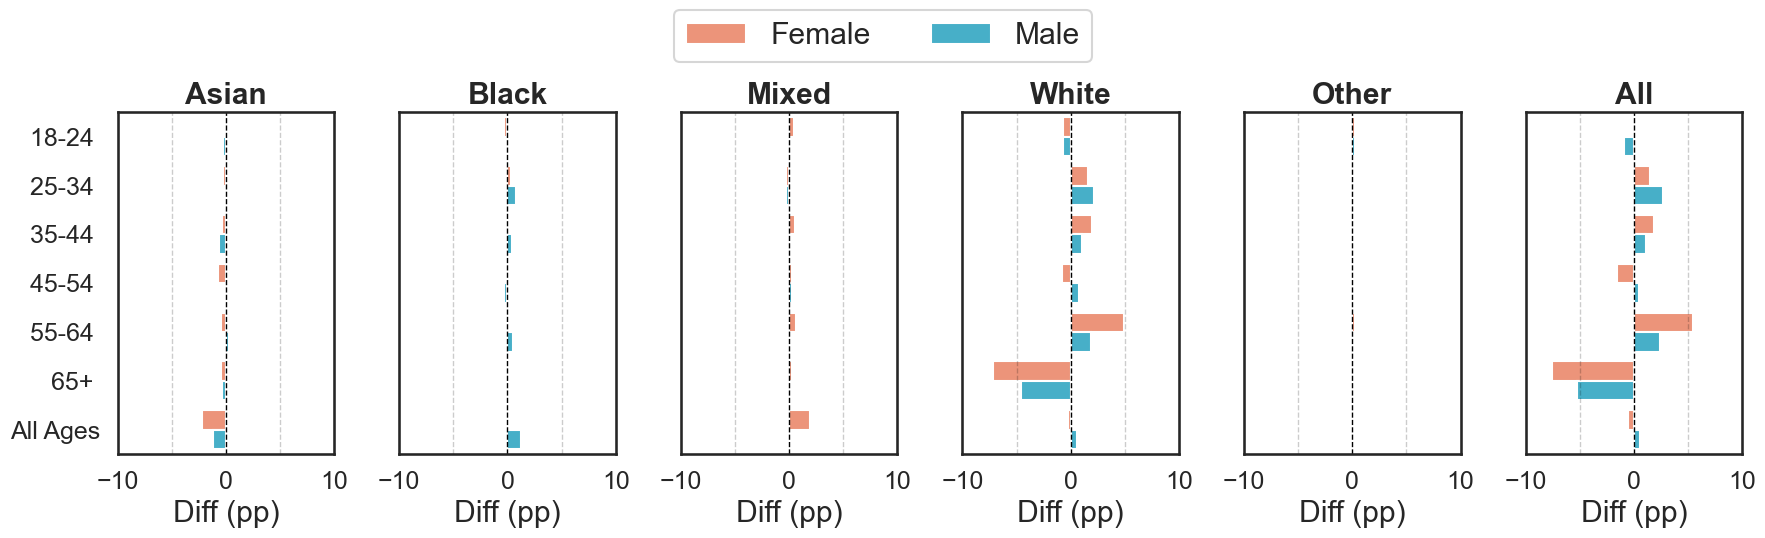

In [12]:
# UK
plot_census_diffs(
    uk_census, uk_ours, shared_ethnicities, "UK (Before Rebalancing)", "uk_before"
)

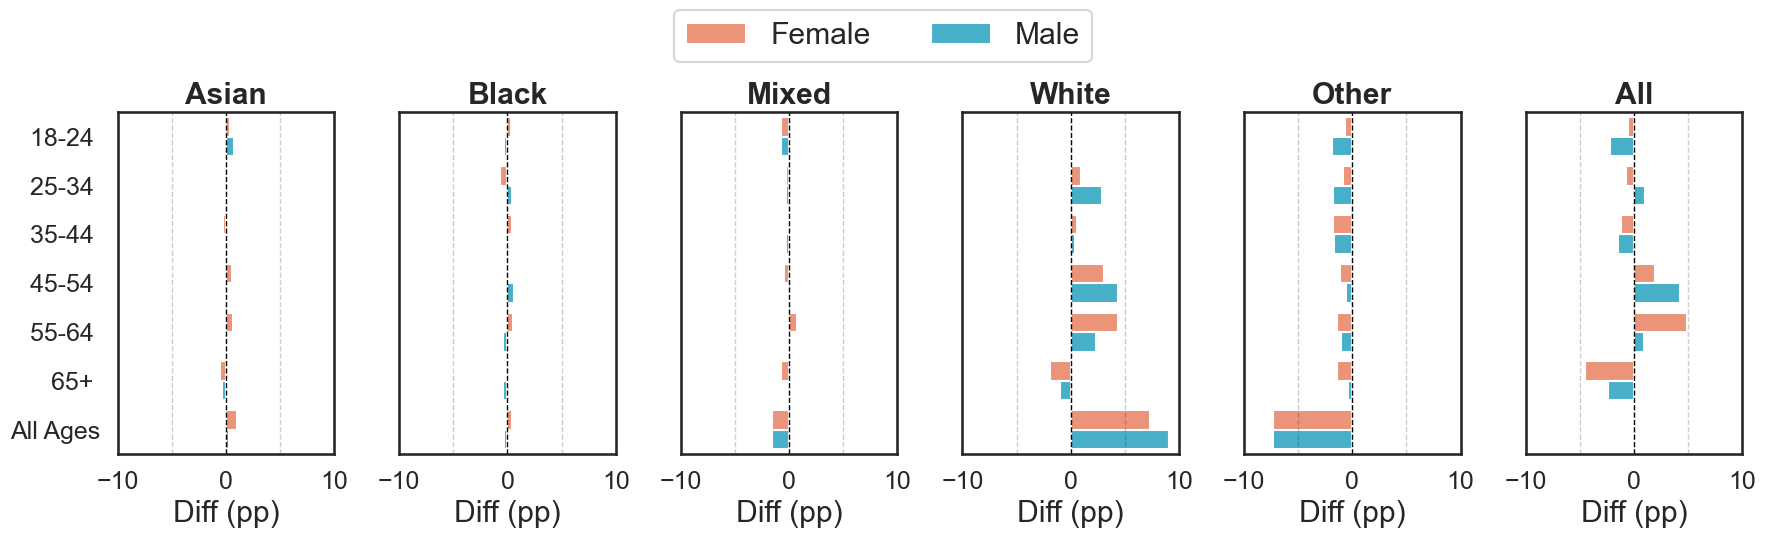

In [13]:
# US
plot_census_diffs(
    us_census, us_ours, shared_ethnicities, "US (Before Rebalancing)", "us_before"
)

# Resampling a More Representative Distribution

In [14]:
def rebalance_sample(study_df, census_df, N_TOTAL):
    SEED = 42
    census_rep_ids = []
    missing = 0
    print("\nSAMPLING....")
    # Iterate through each value
    for AGE in census_df.index:
        for RACE_GENDER in census_df.columns:
            if ("All" in RACE_GENDER) or ("All" in AGE):
                continue
            else:
                gender = RACE_GENDER.split("_")[1]
                eth = RACE_GENDER.split("_")[0]
                subset_df = study_df[
                    (study_df["age"] == AGE)
                    & (study_df["gender"] == gender)
                    & (study_df["ethnicity_remapped"] == eth)
                ]
                # Find value to muliply by in pct
                value = (census_df.loc[AGE, RACE_GENDER]) / 100
                # int truncates which penalises minority groups so add 1
                n_people_raw = value * N_TOTAL
                n_people_sample = int(value * N_TOTAL) + 1
                # Try to sample n_people
                try:
                    sampled = subset_df.sample(n_people_sample, random_state=SEED)
                except:
                    # Else sample everyone
                    print(
                        f"{AGE, RACE_GENDER}: Not enough people to sample, sampling all"
                    )
                    print(f"Needed {n_people_raw}, only have {len(subset_df)}")
                    sampled = subset_df.sample(len(subset_df), random_state=SEED)
                    missing += n_people_sample - len(subset_df)
                # Add ids to list
                census_rep_ids.extend(sampled["user_id"].tolist())
    print("\nFINISHED.\n")
    return census_rep_ids

### Sampling Parameters


In [15]:
LOCATION_COLUMN = "study_locale"
LOCALE_VALUES = {
    "uk": {
        "location_birth_countryISO": "GBR",
        "location_reside_countryISO": "GBR",
        "study_locale": "uk",
    },
    "us": {
        "location_birth_countryISO": "USA",
        "location_reside_countryISO": "USA",
        "study_locale": "us",
    },
}
DATA_SPLIT = "survey_w_balanced_convos"
DATA = data_dict[DATA_SPLIT]
SAMPLE_N = 300

In [16]:
# Note counts for reside and study locales are very similar
display(DATA["location_reside_countryISO"].value_counts()[0:2])
display(DATA["study_locale"].value_counts()[0:2])


# Examine birth country too
display(DATA["location_birth_countryISO"].value_counts()[0:2])

location_reside_countryISO
USA    301
GBR    284
Name: count, dtype: int64

study_locale
us    300
uk    284
Name: count, dtype: int64

location_birth_countryISO
USA    258
GBR    245
Name: count, dtype: int64

In [17]:
# Let's also check originally how many were in these samples
display(data_dict["survey"]["location_reside_countryISO"].value_counts()[0:2])

display(data_dict["survey"]["study_locale"].value_counts()[0:2])

location_reside_countryISO
USA    386
GBR    340
Name: count, dtype: int64

study_locale
us    386
uk    341
Name: count, dtype: int64

### UK Study

Number of binary gender respondents in uk: 283

SAMPLING....
('18-24 years old', 'Black_Female'): Not enough people to sample, sampling all
Needed 0.8346702363548507, only have 0
('18-24 years old', 'White_Female'): Not enough people to sample, sampling all
Needed 11.869146128354977, only have 9
('18-24 years old', 'Asian_Male'): Not enough people to sample, sampling all
Needed 1.9105549914659228, only have 1
('18-24 years old', 'Mixed_Male'): Not enough people to sample, sampling all
Needed 0.6755658897058715, only have 0
('18-24 years old', 'White_Male'): Not enough people to sample, sampling all
Needed 12.048301372294851, only have 9
('25-34 years old', 'Asian_Female'): Not enough people to sample, sampling all
Needed 3.040936242383466, only have 2
('25-34 years old', 'Mixed_Female'): Not enough people to sample, sampling all
Needed 0.8629194403035111, only have 0
('25-34 years old', 'Asian_Male'): Not enough people to sample, sampling all
Needed 2.6910464958382474, only have 2
('25

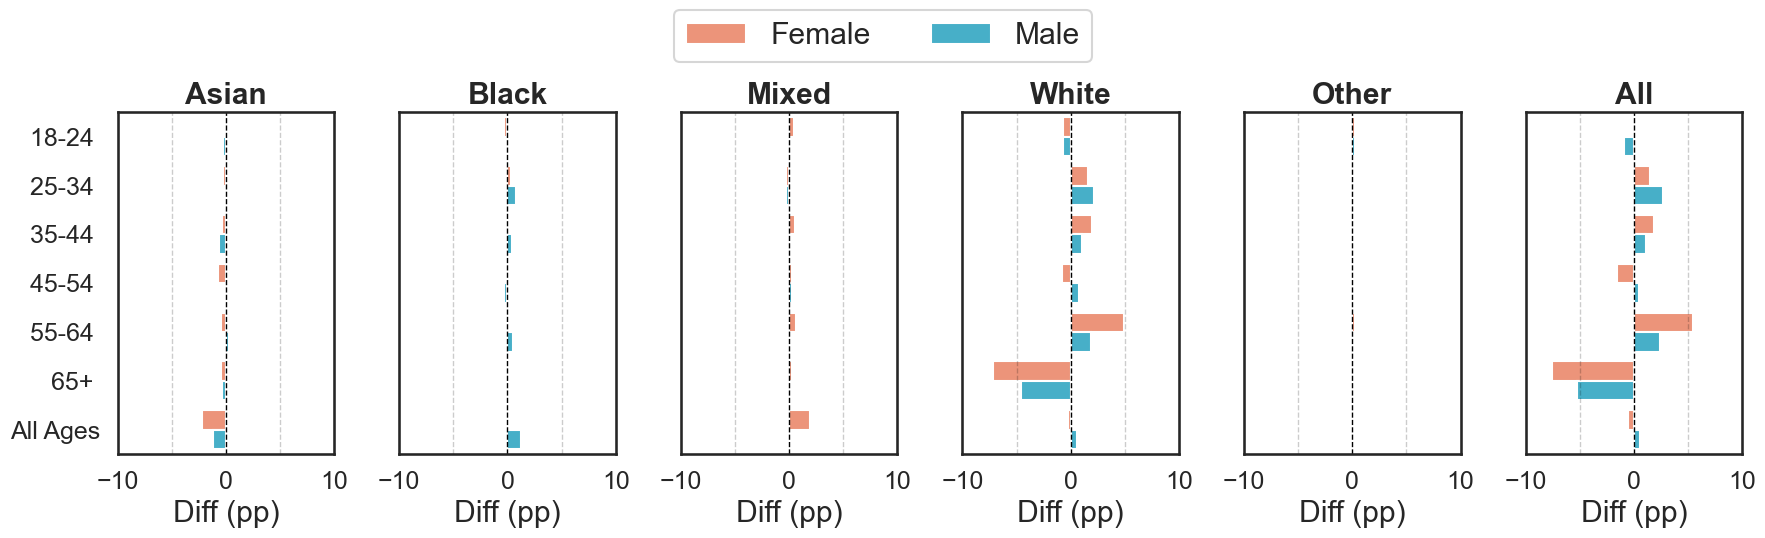

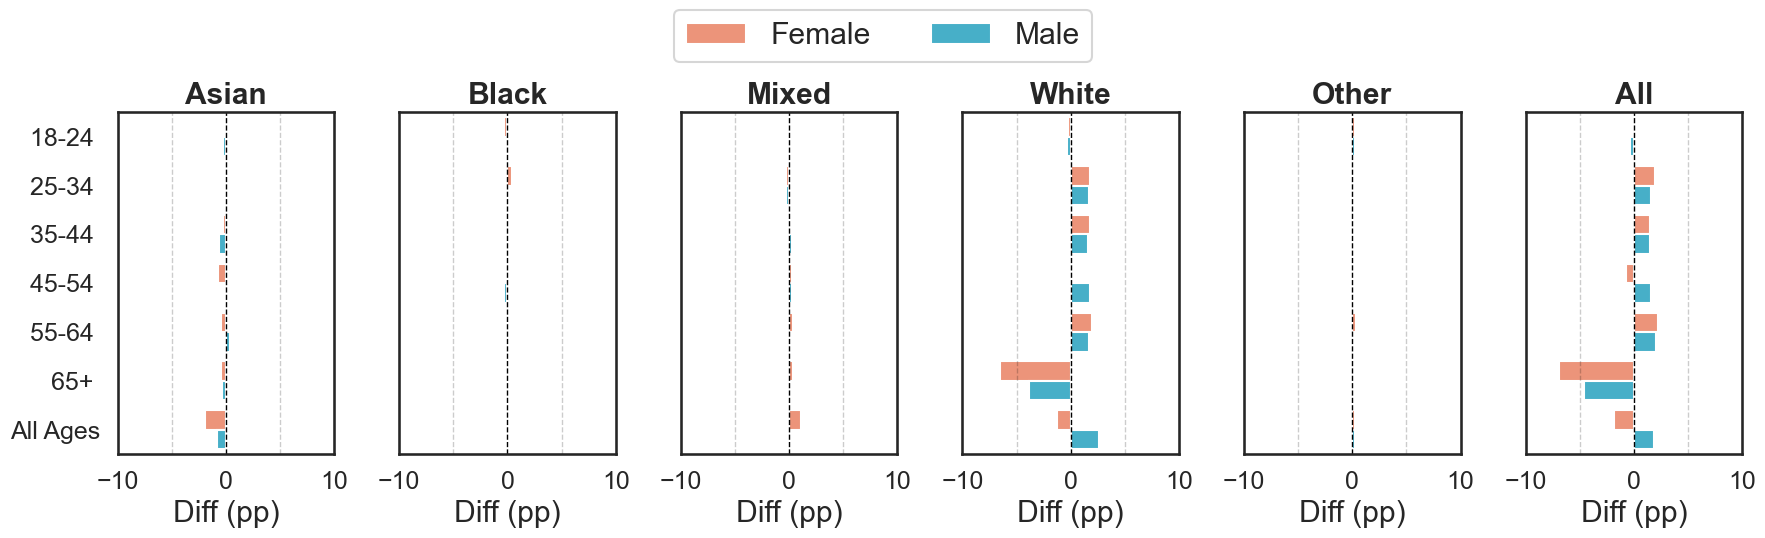

In [18]:
# Get our original data
LOCALE_ = "uk"
LOCALE = LOCALE_VALUES[LOCALE_][LOCATION_COLUMN]
uk_ours = get_our_crosstabs_by_census(DATA, LOCALE, uk_eth_mapping, LOCATION_COLUMN)

# Subset data ready for rebalancing
study = DATA[DATA[LOCATION_COLUMN] == LOCALE]
study = study.copy()
# Remap ethnicity
study["ethnicity_remapped"] = (
    study["ethnicity_categorised"].map(uk_eth_mapping).dropna()
)

# Keep binary genders for census comparison
study = study[study["gender"].isin(["Female", "Male"])]

# Run rebalancing
census_rep_ids = rebalance_sample(study, uk_census, SAMPLE_N)
new_uk_study = study[study["user_id"].isin(census_rep_ids)]
print(f"Number of resampled respondents in {LOCALE}: {len(new_uk_study)}")
uk_ours_rep = pivot_counts(new_uk_study)

# Plot
plot_census_diffs(
    uk_census, uk_ours, shared_ethnicities, "UK (Before Rebalancing)", "uk_before"
)
plot_census_diffs(
    uk_census, uk_ours_rep, shared_ethnicities, "UK (After Rebalancing)", "uk_after"
)

### US Study

Number of binary gender respondents in us: 297

SAMPLING....
('18-24 years old', 'White_Male'): Not enough people to sample, sampling all
Needed 8.276352315160768, only have 8
('18-24 years old', 'Black_Male'): Not enough people to sample, sampling all
Needed 2.1484113255205344, only have 1
('18-24 years old', 'Mixed_Male'): Not enough people to sample, sampling all
Needed 2.372010899572551, only have 0
('18-24 years old', 'Other_Male'): Not enough people to sample, sampling all
Needed 5.5366376375914905, only have 0
('18-24 years old', 'Mixed_Female'): Not enough people to sample, sampling all
Needed 2.227339819221372, only have 0
('18-24 years old', 'Other_Female'): Not enough people to sample, sampling all
Needed 5.222376032304719, only have 3
('25-34 years old', 'Mixed_Male'): Not enough people to sample, sampling all
Needed 3.0178077589432455, only have 2
('25-34 years old', 'Other_Male'): Not enough people to sample, sampling all
Needed 7.433494542440951, only have 2
('25-34 year

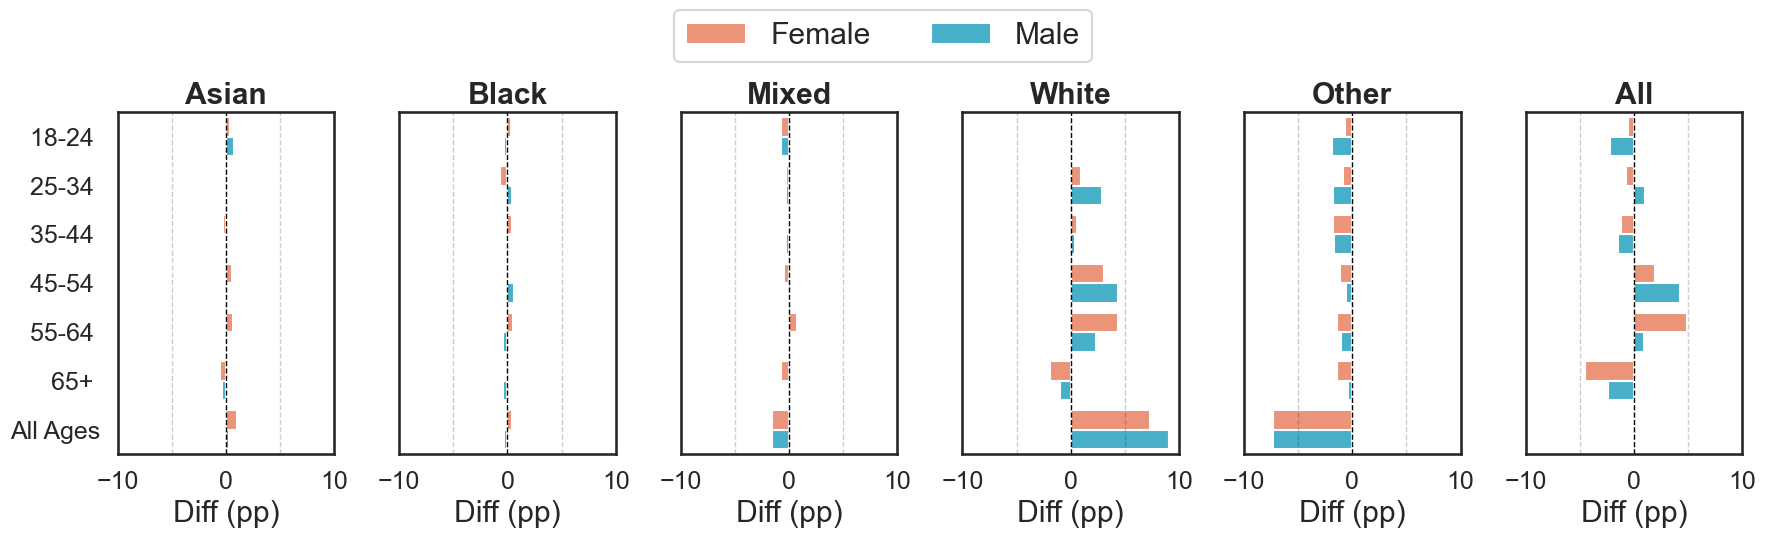

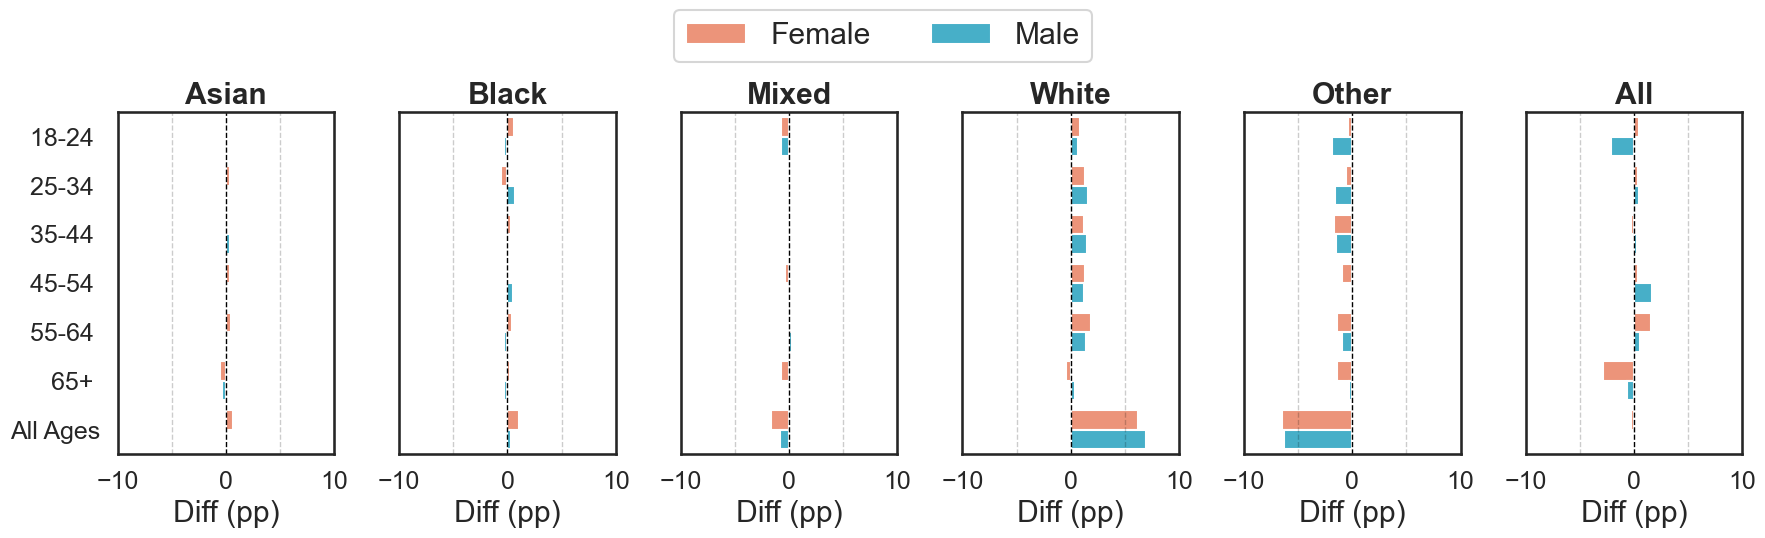

In [19]:
# Get our original data
LOCALE_ = "us"
LOCALE = LOCALE_VALUES[LOCALE_][LOCATION_COLUMN]
us_ours = get_our_crosstabs_by_census(DATA, LOCALE, us_eth_mapping, LOCATION_COLUMN)

# Subset data ready for rebalancing
study = DATA[DATA[LOCATION_COLUMN] == LOCALE]
study = study.copy()
# Remap ethnicity
study["ethnicity_remapped"] = (
    study["ethnicity_categorised"].map(us_eth_mapping).dropna()
)

# Keep binary genders for census comparison
study = study[study["gender"].isin(["Female", "Male"])]

# Run rebalancing
census_rep_ids = rebalance_sample(study, us_census, SAMPLE_N)
new_us_study = study[study["user_id"].isin(census_rep_ids)]
print(f"Number of resampled respondents in {LOCALE}: {len(new_us_study)}")
us_ours_rep = pivot_counts(new_us_study)

# Plot
plot_census_diffs(
    us_census, us_ours, shared_ethnicities, "US (Before Rebalancing)", "us_before"
)
plot_census_diffs(
    us_census, us_ours_rep, shared_ethnicities, "US (After Rebalancing)", "us_after"
)

# Export Results

Now let's add a flag in our dataset for REP and if it's in the balanced subset.

In [20]:
# Load from file to get clean version
conversations = pd.read_json(INPUT_PATH / "conversations.jsonl", lines=True)

ids_with_balanced_subset = conversations["user_id"][
    conversations["included_in_balanced_subset"] == True
].unique()

print(
    "Number of respondents with balanced conversations:",
    len(ids_with_balanced_subset),
)


print(
    "Number of respondents (balanced and unbalanced):",
    conversations["user_id"].nunique(),
)

Number of respondents with balanced conversations: 1246
Number of respondents (balanced and unbalanced): 1396


In [21]:
# Load from file to get clean version
survey = pd.read_json(INPUT_PATH / "survey.jsonl", lines=True)
survey["included_in_US_REP"] = survey["user_id"].isin(new_us_study["user_id"].tolist())
survey["included_in_UK_REP"] = survey["user_id"].isin(new_uk_study["user_id"].tolist())

survey["included_in_balanced_subset"] = survey["user_id"].isin(ids_with_balanced_subset)

# Resave
survey.to_json(INPUT_PATH / "survey.jsonl", orient="records", lines=True)

## Check Overlap with Balanced Subset

In [22]:
survey = pd.read_json(INPUT_PATH / "survey.jsonl", lines=True)

survey.columns

Index(['user_id', 'survey_only', 'num_completed_conversations',
       'timing_duration_s', 'timing_duration_mins', 'generated_datetime',
       'consent', 'consent_age', 'lm_familiarity', 'lm_indirect_use',
       'lm_direct_use', 'lm_frequency_use', 'self_description',
       'system_string', 'age', 'gender', 'employment_status', 'education',
       'marital_status', 'english_proficiency', 'study_id', 'study_locale',
       'religion', 'ethnicity', 'location', 'lm_usecases', 'stated_prefs',
       'order_lm_usecases', 'order_stated_prefs', 'included_in_US_REP',
       'included_in_UK_REP', 'included_in_balanced_subset'],
      dtype='object')

In [23]:
survey["included_in_balanced_subset"].value_counts()

included_in_balanced_subset
True     1246
False     254
Name: count, dtype: int64

In [24]:
survey[["included_in_balanced_subset", "included_in_US_REP"]].value_counts()

included_in_balanced_subset  included_in_US_REP
True                         False                 1016
False                        False                  254
True                         True                   230
Name: count, dtype: int64

In [25]:
survey[["included_in_balanced_subset", "included_in_UK_REP"]].value_counts()

included_in_balanced_subset  included_in_UK_REP
True                         False                 1003
False                        False                  254
True                         True                   243
Name: count, dtype: int64